## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import lightgbm as lgb

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


## Load Data

In [3]:
## load in Train Set
X_train_path = "../data/model_training/preprocessed_data/training/X_train_enc.parquet"
X_train = pd.read_parquet(X_train_path)
y_train_path = "../data/model_training/preprocessed_data/training/y_train.parquet"
y_train = pd.read_parquet(y_train_path)

### convert y_train into int
y_train = y_train.values.ravel()
y_train = y_train.astype(int)

## load in Test Set
X_test_path = "../data/model_training/preprocessed_data/test/X_test_enc.parquet"
X_test = pd.read_parquet(X_test_path)
y_test_path = "../data/model_training/preprocessed_data/test/y_test.parquet"
y_test = pd.read_parquet(y_test_path)

### convert y_test into int
y_test = y_test.values.ravel()
y_test = y_test.astype(int)

## load in Validation Set
X_val_path = "../data/model_training/preprocessed_data/validation/X_val_enc.parquet"
X_val = pd.read_parquet(X_val_path)
y_val_path = "../data/model_training/preprocessed_data/validation/y_val.parquet"
y_val = pd.read_parquet(y_val_path)

### convert y_val into int
y_val = y_val.values.ravel()
y_val = y_val.astype(int)

## Create Function for LightGBM Classifier

In [4]:
def lgbmodel(X_train, y_train, X_test, y_test,
            num_leaves = 31, max_depth = -1, n_estimators = 100, min_child_weight = 0.001,
            min_child_samples = 20, reg_alpha = 0, reg_lambda = 0, scale_pos_weight = None):

    ## create base random forest classifier
    lgbm = lgb.LGBMClassifier(random_state = 42, num_leaves = num_leaves, max_depth = max_depth, n_estimators = n_estimators, 
                                min_child_weight = min_child_weight, min_child_samples = min_child_samples, 
                                reg_alpha = reg_alpha, reg_lambda = reg_lambda, scale_pos_weight = scale_pos_weight)

    lgbm.fit(X_train, y_train)

    ## predict labels in for training and test set
    y_train_pred = lgbm.predict(X_train)
    y_test_pred = lgbm.predict(X_test)
    print('Model training accuracy score with LightGBM : {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
    print('Model testing accuracy score with LightGBM : {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))
    
    ## confusion matrix plot
    plot_confusion_matrix(lgbm, X_test, y_test) 
    plt.title('LightGBM Confusion Matrix')
    plt.show()
    
    ## define roc metrics
    y_pred1 = lgbm.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
    roc_auc = roc_auc_score(y_test, y_pred1)

    ## plot roc curve
    plt.figure()
    plt.plot(fpr, tpr, label = 'LightGBM Classifier (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()

    ## define pr metrics
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred1)
    auc_pr = auc(recall, precision)

    ## plot pr curve   
    plt.figure()
    plt.plot(recall, precision, label = 'LightGBM Classifier (area = %0.2f)' % auc_pr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Precision-Recall')
    plt.legend(loc = "lower right")
    plt.show()

    results = {"fpr": fpr, "tpr": tpr, "roc": roc_auc, "precision": precision, "recall": recall, "pr": auc_pr}

    return results

## Stages to perform

1. Classification on all columns
2. Classification on selected features from RFE
3. Classification on features from PCA
4. Hyperparameter tune best model (RFE or PCA)

### Stage 1: Classification on all columns

Model training accuracy score with LightGBM : 0.9357
Model testing accuracy score with LightGBM : 0.9550


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


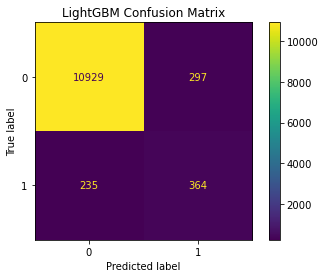

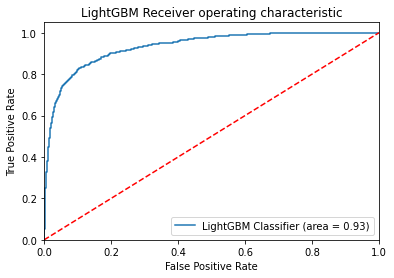

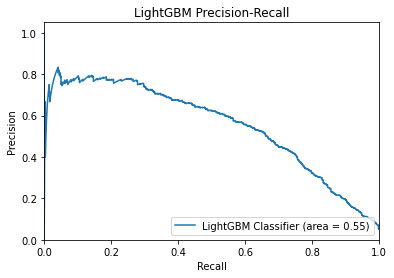

In [5]:
base = lgbmodel(X_train, y_train, X_test, y_test)

### Stage 2: Classification on selected features from RFE

- Create function to do RFE
- Perform RFE
- Perform Classification

In [8]:
def var_selection(X_train, y_train):
    ## instantiate classifier
    rf_vs = lgb.LGBMClassifier(random_state = 42)
    rf_vs.fit(X_train, y_train)

    ## do RFE
    sel = RFE(rf_vs)
    sel.fit(X_train, y_train)

    ## return best_var
    best_var = X_train.columns[(sel.get_support())]
    print(best_var)
    return best_var

In [9]:
best_var = var_selection(X_train, y_train)

Index(['reads_count', 'dwelling_time_-1_25', 'dwelling_time_-1_75',
       'std_-1_25', 'std_-1_75', 'std_-1_min', 'mean_-1_25', 'mean_-1_75',
       'mean_-1_min', 'mean_-1_max', 'dwelling_time_0_25',
       'dwelling_time_0_50', 'dwelling_time_0_75', 'dwelling_time_0_mean',
       'std_0_25', 'std_0_50', 'std_0_75', 'std_0_mean', 'std_0_min',
       'std_0_max', 'mean_0_25', 'mean_0_50', 'mean_0_75', 'mean_0_mean',
       'mean_0_min', 'mean_0_max', 'dwelling_time_+1_mean', 'std_+1_50',
       'std_+1_75', 'std_+1_min', 'mean_+1_25', 'mean_+1_50', 'mean_+1_75',
       'mean_+1_min', 'mean_+1_max', 'relative_position'],
      dtype='object')


Model training accuracy score with LightGBM : 1.0000
Model testing accuracy score with LightGBM : 0.9529


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


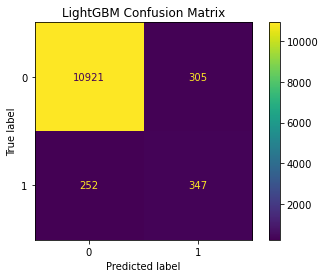

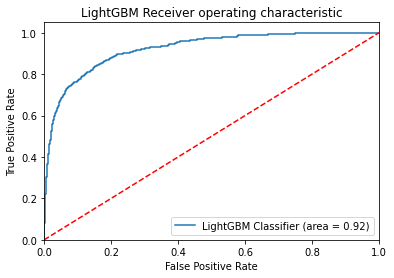

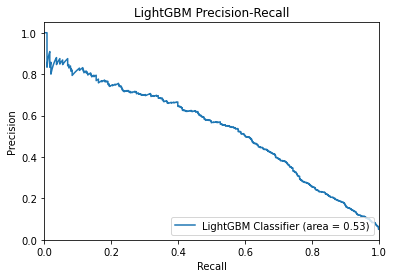

In [11]:
lgb_model = lgbmodel(X_train[best_var], y_train, X_test[best_var], y_test)

### Stage 3: Classification on Features from PCA

In [12]:
pca = PCA(0.95) # preserve 95% of variability in the data
pca.fit(X_train)
pca.n_components_

26

In [13]:
## transform training data using PCA features
X_train_pca = pd.DataFrame(pca.transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
X_val_pca = pd.DataFrame(pca.transform(X_val))

Model training accuracy score with LightGBM : 1.0000
Model testing accuracy score with LightGBM : 0.9419


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


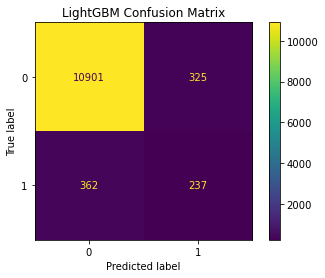

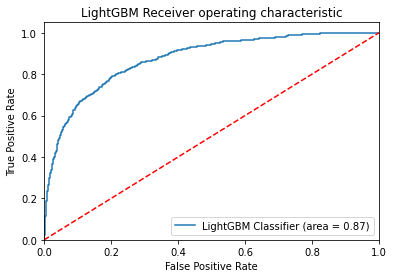

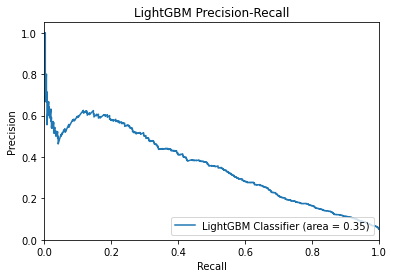

In [14]:
pca_model = lgbmodel(X_train_pca, y_train, X_test_pca, y_test)

#### Comparison of Models using RFE and PCA

In [15]:
models = [lgb_model, pca_model]
titles = ["RFE Selected Features", "PCA Features"]

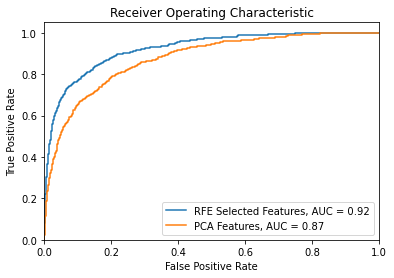

In [16]:
# ROC Curve
for m, t in zip(models, titles):
    plt.plot(m["fpr"], m["tpr"], label = f"{t}, AUC = %0.2f" % m["roc"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = "lower right")

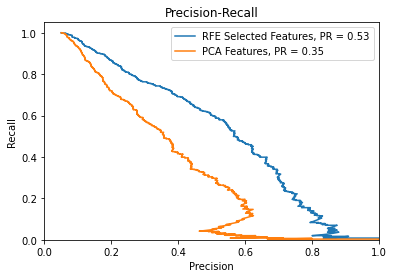

In [17]:
# PR Curve
for m, t in zip(models, titles):
    plt.plot(m["precision"], m["recall"], label = f"{t}, PR = %0.2f" % m["pr"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall')
    plt.legend(loc = "upper right")

### Stage 4: Hyperparameter Tuning on Best Model (RFE)

- Create function for hyperparameter tuning
- Create grid of parameters to search through
- Perform hyperparameter tuning
- Perform classification using selected hyperparameters

In [18]:
def params_tuning(random_grid, X_val, y_val):
    lg = lgb.LGBMClassifier(objective='binary', metric = 'auc', random_state = 42)
    lgbm_random = RandomizedSearchCV(estimator = lg, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)
    lgbm_random.fit(X_val, y_val)
    print(lgbm_random.best_params_)
    return lgbm_random.best_params_

In [19]:
## Number of trees in random forest
n_estimators = [int(x) for x in np.arange(100, 301, 5)]

## Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 110, 10)]
max_depth.append(None)

num_leaves = [int(x) for x in np.arange(10, 201, 10)]
min_child_weight = [4.0, 8.0, 10.0, 12.0, 12.5, 15.0]
scale_pos_weight = [2,5,7,9,11,13,15]
reg_alpha = [0.1, 0.5, 1, 1.5, 2, 2.5]
reg_lambda = [0.5,1,1.5,1.75,2, 2.25, 2.5, 3]
min_child_samples = [5, 10, 15, 20, 25, 30, 50, 60, 80, 100]

## Create the random grid
random_grid = {'num_leaves': num_leaves,
    'reg_alpha': reg_alpha,
    'reg_lambda':reg_lambda,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'scale_pos_weight': scale_pos_weight,
    'min_child_samples': min_child_samples
    }

print(random_grid)

{'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'reg_alpha': [0.1, 0.5, 1, 1.5, 2, 2.5], 'reg_lambda': [0.5, 1, 1.5, 1.75, 2, 2.25, 2.5, 3], 'n_estimators': [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_child_weight': [4.0, 8.0, 10.0, 12.0, 12.5, 15.0], 'scale_pos_weight': [2, 5, 7, 9, 11, 13, 15], 'min_child_samples': [5, 10, 15, 20, 25, 30, 50, 60, 80, 100]}


In [20]:
best_params = params_tuning(random_grid, X_val[best_var], y_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 100, 'n_estimators': 270, 'min_child_weight': 4.0, 'min_child_samples': 60, 'max_depth': 80}


Model training accuracy score with LightGBM : 1.0000
Model testing accuracy score with LightGBM : 0.9485


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


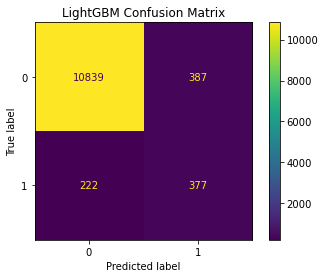

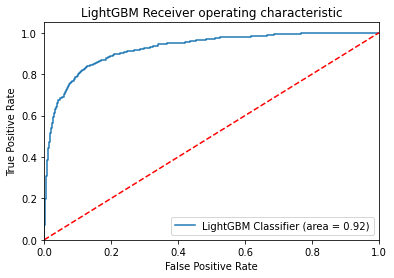

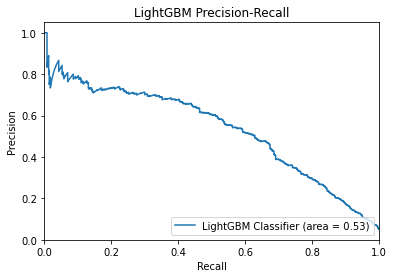

In [21]:
hyperparameter_model = lgbmodel(X_train[best_var], y_train, X_test[best_var], y_test,
                                num_leaves = 100, max_depth = 80, n_estimators = 270, min_child_weight = 4,
                                min_child_samples = 60, reg_alpha = 1, reg_lambda = 1, scale_pos_weight = 2)

## Comparison of all 3 Models

In [22]:
models = [lgb_model, pca_model, hyperparameter_model]
titles = ["RFE Selected Features", "PCA Features", "RFE with  Tuning"]

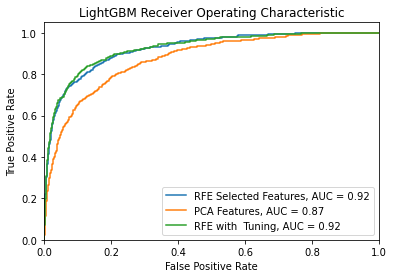

In [24]:
# ROC Curve
for m, t in zip(models, titles):
    plt.plot(m["fpr"], m["tpr"], label = f"{t}, AUC = %0.2f" % m["roc"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM Receiver Operating Characteristic')
    plt.legend(loc = "lower right")

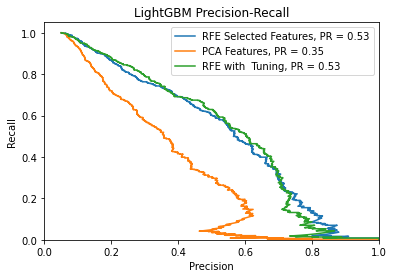

In [25]:
# PR Curve
for m, t in zip(models, titles):
    plt.plot(m["precision"], m["recall"], label = f"{t}, PR = %0.2f" % m["pr"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('LightGBM Precision-Recall')
    plt.legend(loc = "upper right")